In [11]:
from os.path import join as pjoin
from tempfile import mkdtemp
import os
import numpy as np
from multiprocessing import Pool
from functools import partial
import time
import imaging as ic
from glob import glob
import pylab as plt
from tifffile import imread,imsave,TiffWriter
from imaging import reconstruct2PStack
files = glob('/mnt/bkrunch/h/data/2photon/raw/170519_JC027_2P_JC/run04_closedloop/*.tif')
destinationPath = '/quadraraid/data/2photon/rec'
#stack = ic.TiffStack(files)
#print('Done.')


Line shift is: 1 pixels


<IPython.core.display.Javascript object>


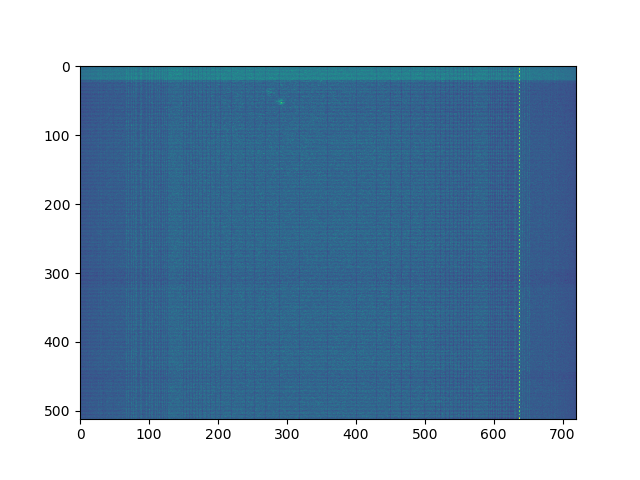

In [12]:
def reconstruct2PTifFiles(files, destinationPath):
    data = []
    for f in files[:3]:
        dat = imread(f)
        data.append(ic.reconstruct2PStack(dat))
    data = np.concatenate(data,axis=0)

    shift = ic.estimate2PLineShift(data)

    print('Line shift estimate: {0} pixels'.format(shift))
    recfilenames = [pjoin(destinationPath,f.split('/raw/')[-1]) for f in files]
    tstart = time.time()
    nworkers = 16


    def reconstruct2PTifFile(filename,destination,shift = 0):
        if os.path.isfile(destination):
            raise
        data = imread(filename)
        recdata = reconstruct2PStack(data,shift=shift)
    
        with TiffWriter(destination) as tf:
            for dd in range(recdata.shape[0]):
                tf.save(recdata[dd,:,:].astype('uint16'))
    def test(fnames,shift = 0):
        filename,destination = fnames
        reconstruct2PTifFile(filename,destination,shift)

    func = partial(test, shift = shift)
    if not os.path.isdir(os.path.dirname(recfilenames[0])):
        os.makedirs(os.path.dirname(recfilenames[0]))
#for f,r in zip(stack.filenames[:2],recfilenames[:2]):
#    reconstruct2PTifFile(f,r)

    pool = Pool(nworkers)
    res = pool.map_async(func,zip(files,recfilenames))
    pool.close()
    pool.join()
    print('Done in {0} min'.format((time.time()-tstart)/60.))

In [13]:
recfilenames = [pjoin(destinationPath,f.split('/raw/')[-1]) for f in files]
tstart = time.time()
nworkers = 16


def reconstruct2PTifFile(filename,destination,shift = 0):
    if os.path.isfile(destination):
        raise
    data = imread(filename)
    recdata = reconstruct2PStack(data,shift=shift)
    
    with TiffWriter(destination) as tf:
        for dd in range(recdata.shape[0]):
            tf.save(recdata[dd,:,:].astype('uint16'))
def test(fnames,shift = 0):
    filename,destination = fnames
    reconstruct2PTifFile(filename,destination,shift)

func = partial(test, shift = shift)
if not os.path.isdir(os.path.dirname(recfilenames[0])):
    os.makedirs(os.path.dirname(recfilenames[0]))
#for f,r in zip(stack.filenames[:2],recfilenames[:2]):
#    reconstruct2PTifFile(f,r)

pool = Pool(nworkers)
res = pool.map_async(func,zip(files,recfilenames))
pool.close()
pool.join()
print('Done in {0} min'.format((time.time()-tstart)/60.))

Done in 3.51723846992 min
